C:\v env\sales_forcast\src\utils\data_preprocessing.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data['item_qty'].fillna(0, inplace=True)


,store,profile,size
0,ABC,Moderate,Medium
1,XYZ,High,Large


,date_id,item_dept,item_qty,net_sales,store,item,invoice_num
0,2021-11-01,Grocery,1.0,160.0,XYZ,16620,1475459.0
1,2021-11-01,Grocery,2.0,480.0,XYZ,32365,1475459.0
2,2021-11-01,Grocery,1.0,127.0,XYZ,31349,1475459.0
3,2021-11-01,Household,2.0,110.0,XYZ,1266,1475475.0
4,2021-11-01,Household,1.0,150.0,XYZ,114920,1475475.0


,date_id,item_dept,item_qty,net_sales,store,item,invoice_num
0,2022-02-01,Beverages,2.0,480.0,XYZ,112360,1495518.0
1,2022-02-01,Beverages,1.0,202.0,XYZ,111195,1495518.0
2,2022-02-01,Household,1.0,165.0,XYZ,41212,1495572.0
3,2022-02-01,Household,2.0,480.0,XYZ,123476,1495572.0
4,2022-02-01,Grocery,2.0,660.0,XYZ,106668,1495572.0


Summary Statistics of Training Data:
                             date_id       item_qty      net_sales  \
count                         612332  612332.000000  612332.000000   
mean   2021-12-16 16:26:09.266345472       1.534273     335.155858   
min              2021-11-01 00:00:00     -59.000000  -15250.000000   
25%              2021-11-25 00:00:00       1.000000     125.000000   
50%              2021-12-17 00:00:00       1.000000     215.000000   
75%              2022-01-08 00:00:00       1.698000     371.000000   
max              2022-01-31 00:00:00     880.000000  316880.280000   
std                              NaN       3.061869     825.643851   

                item   invoice_num  
count  612332.000000  5.909050e+05  
mean    67650.422302  4.231940e+06  
min       906.000000  1.475419e+06  
25%     14345.000000  2.581948e+06  
50%     89893.000000  4.597865e+06  
75%    117021.000000  5.598286e+06  
max    124146.000000  9.354809e+06  
std     48901.214022  1.704193e+06  

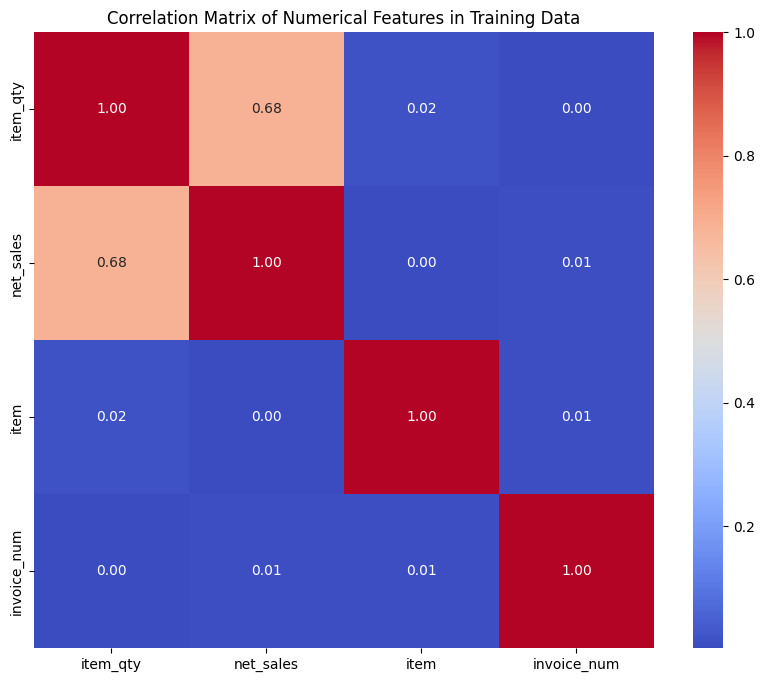

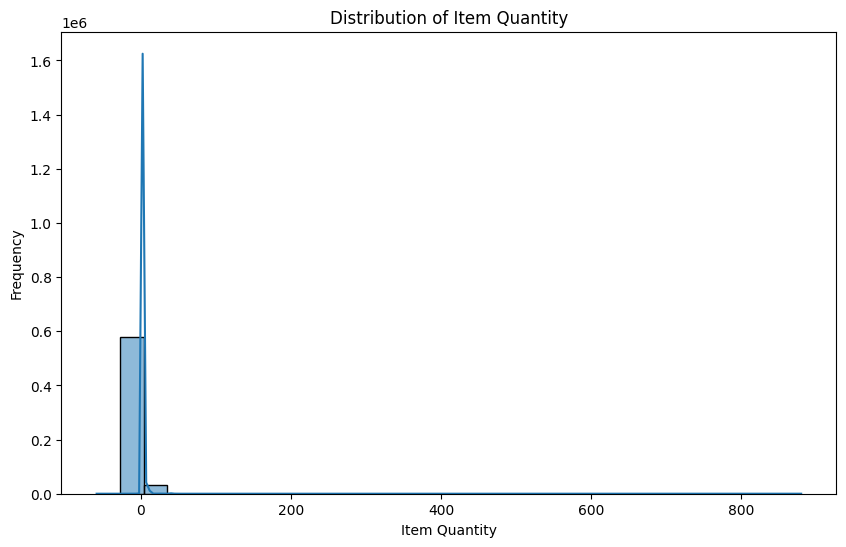

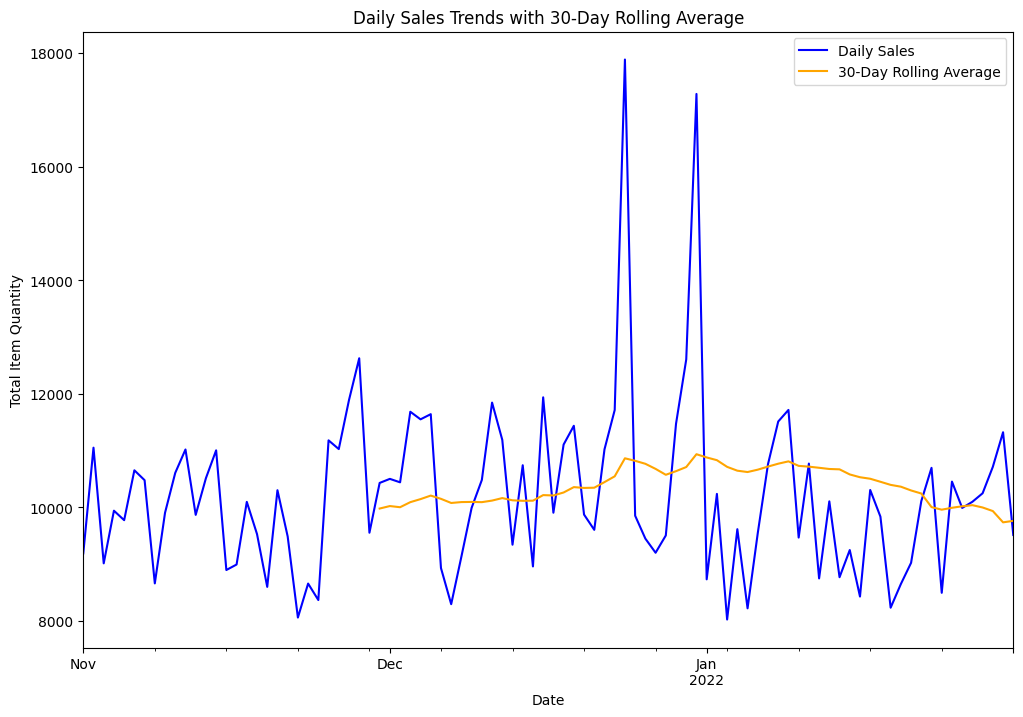

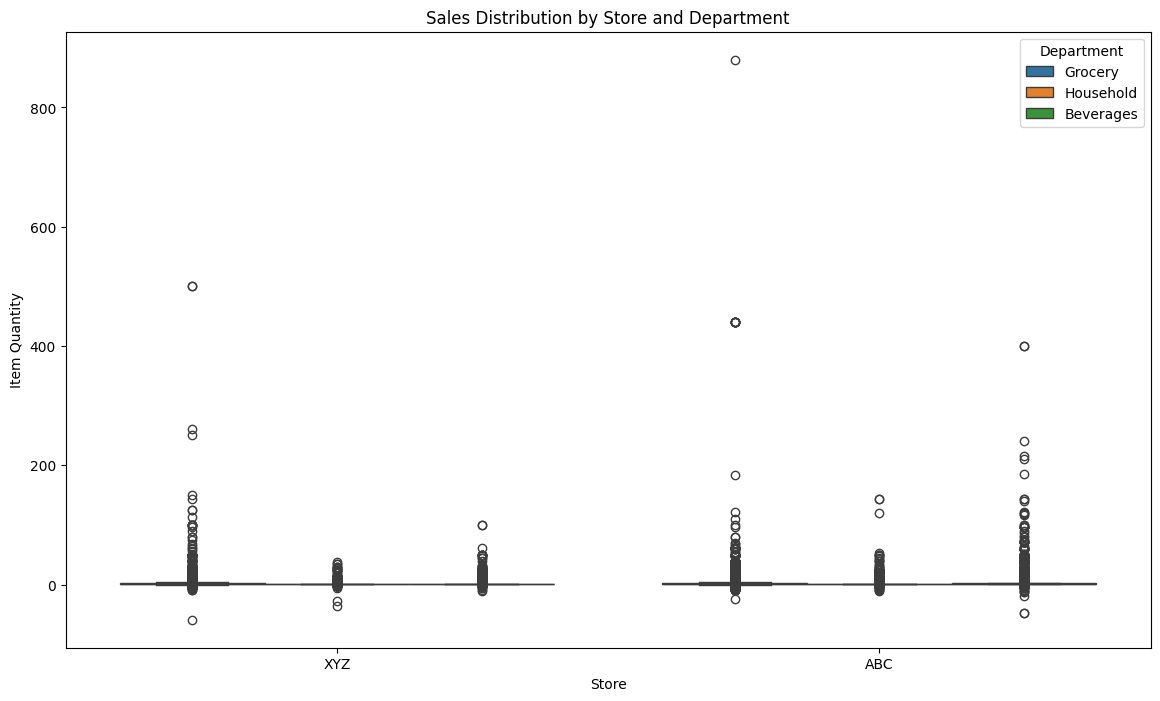

<Figure size 1400x700 with 0 Axes>

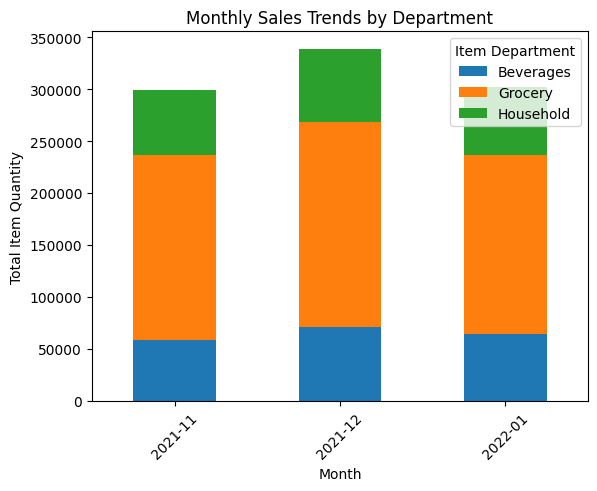

<Figure size 1200x600 with 0 Axes>

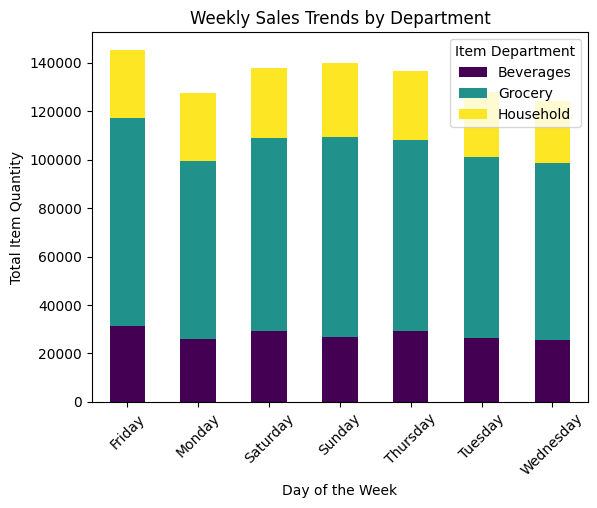

Additional Insights from Exploratory Analysis:
- The correlation matrix suggests a strong positive correlation between certain numerical features, which may indicate multicollinearity.
- The distribution of item quantity reveals a right-skewed distribution, indicating that most sales are concentrated on lower quantities.
- Sales trends over time show distinct patterns, with a rolling average smoothing out fluctuations and highlighting underlying trends.
- Analysis by store and department shows varying sales distributions, with some departments consistently performing better in certain stores.
- Seasonal analysis reveals both monthly and weekly patterns, with certain days of the week and months showing higher sales volumes.


In [3]:

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get the project root directory (one level up from the current directory)
project_root = os.path.abspath("..")

# Add the project root directory to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)
    
# Import necessary modules from the project
from src.utils.data_loader import load_data
from src.utils.data_preprocessing import clean_data

# Load the data
outlet_info_path = '../data/outlet_info.csv'
training_data_path = '../data/cleaned_training_data.csv'
test_data_path = '../data/cleaned_test_data.csv'

outlet_info, training_data, test_data = load_data(outlet_info_path, training_data_path, test_data_path)

# Clean the training data
training_data = clean_data(training_data)

# Display the first few rows of each dataset
display(outlet_info.head())
display(training_data.head())
display(test_data.head())

# Summary statistics of the training data
print("Summary Statistics of Training Data:")
print(training_data.describe())

# Check for missing values
print("\nMissing Values in Training Data:")
print(training_data.isnull().sum())

# Additional Exploratory Analysis
## Correlation Matrix (only numerical columns)
plt.figure(figsize=(10, 8))
numerical_data = training_data.select_dtypes(include=['float64', 'int64'])  # Select only numerical columns
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features in Training Data')
plt.show()

## Distribution of item_qty
plt.figure(figsize=(10, 6))
sns.histplot(training_data['item_qty'], bins=30, kde=True)
plt.title('Distribution of Item Quantity')
plt.xlabel('Item Quantity')
plt.ylabel('Frequency')
plt.show()

## Sales trends over time with rolling average
plt.figure(figsize=(12, 8))
training_data.set_index('date_id')['item_qty'].resample('D').sum().plot(label='Daily Sales', color='blue')
training_data.set_index('date_id')['item_qty'].resample('D').sum().rolling(window=30).mean().plot(label='30-Day Rolling Average', color='orange')
plt.title('Daily Sales Trends with 30-Day Rolling Average')
plt.ylabel('Total Item Quantity')
plt.xlabel('Date')
plt.legend()
plt.show()

## Sales by Store and Department
plt.figure(figsize=(14, 8))
sns.boxplot(x='store', y='item_qty', hue='item_dept', data=training_data)
plt.title('Sales Distribution by Store and Department')
plt.xlabel('Store')
plt.ylabel('Item Quantity')
plt.legend(title='Department')
plt.show()

# Investigate seasonality (monthly and weekly trends)
training_data['month'] = training_data['date_id'].dt.to_period('M')
training_data['day_of_week'] = training_data['date_id'].dt.day_name()

monthly_sales = training_data.groupby(['month', 'item_dept'])['item_qty'].sum().unstack()
weekly_sales = training_data.groupby(['day_of_week', 'item_dept'])['item_qty'].sum().unstack()

plt.figure(figsize=(14, 7))
monthly_sales.plot(kind='bar', stacked=True)
plt.title('Monthly Sales Trends by Department')
plt.ylabel('Total Item Quantity')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(title='Item Department')
plt.show()

plt.figure(figsize=(12, 6))
weekly_sales.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Weekly Sales Trends by Department')
plt.ylabel('Total Item Quantity')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.legend(title='Item Department')
plt.show()

# Additional Findings and Insights
print("Additional Insights from Exploratory Analysis:")
print("- The correlation matrix suggests a strong positive correlation between certain numerical features, which may indicate multicollinearity.")
print("- The distribution of item quantity reveals a right-skewed distribution, indicating that most sales are concentrated on lower quantities.")
print("- Sales trends over time show distinct patterns, with a rolling average smoothing out fluctuations and highlighting underlying trends.")
print("- Analysis by store and department shows varying sales distributions, with some departments consistently performing better in certain stores.")
print("- Seasonal analysis reveals both monthly and weekly patterns, with certain days of the week and months showing higher sales volumes.")
